In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.io as sio
import scipy.signal as scs
from matplotlib.colors import LogNorm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
import glob
import os

# Trabajo Práctico 2

## Ejercicio 1

In [87]:
p01 = sio.loadmat('dataset/P01.mat')

In [88]:
type(p01)

dict

In [89]:
p01_mat = p01['data']

In [90]:
DURACION = 30 * 60  # s
DUR_EPOCH = 1.54  # s
FREQ_SAMPLE = 250  # hz
N_ELECTRODOS = 256 
N_ESTIMULO = 1200
dur_sample = 1 / float(FREQ_SAMPLE)  # s
cant_samples_epoch = DUR_EPOCH / dur_sample
print('Cant samples x epoch: {}'.format(int(cant_samples_epoch)))

Cant samples x epoch: 385


In [91]:
p01_mat.shape

(894, 256, 201)

Interpretamos como: epochs x electrodo x samples

Vemos que hay 201 samples. Recalculamos frecuencia de sampleo.

In [92]:
N_SAMPLES = 201
freq_sample = N_SAMPLES / DUR_EPOCH

### 1.a: Media en electrodos 8, 44, 80, 131, 185 y fft con frecuencias en eje Y y trials en eje X

In [93]:
electrodos_selec = np.array([8,44,80,131,185]) - 1
recorte = p01_mat[:, electrodos_selec, :]
promedio = np.mean(recorte, axis=1)

In [94]:
promedio.shape

(894, 201)

<function __main__.f>

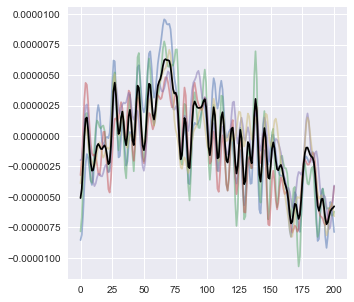

In [95]:
def f(epoch):
    plt.figure(figsize=(5, 5))
    for i in range(5):
        plot(recorte[epoch, i, :], alpha=0.5)
    plot(promedio[epoch, :], color='black') 
interact(f, epoch=(0, 20))

In [96]:
f, Pxx = scs.welch(promedio, fs=freq_sample, axis=1)

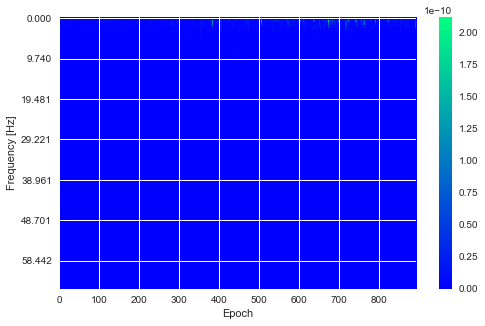

In [98]:
plt.figure(figsize=(8, 5))
imshow(Pxx.T, aspect='auto', cmap=plt.cm.winter)
tick_select = range(0, len(f), 15)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
xlabel('Epoch')
ylabel('Frequency [Hz]')
colorbar()

No se puede observar mucho en este caso. Probamos promediar todos los sujetos.

Para no tener que abrir todas las matrices, vamos a usar una matriz de _epoch_ x _samples_ como acumulador en la que vamos a sumar los valores de cada matriz. Además vamos a contar para cada _epoch_ cuantos valores se sumaron de forma de saber como promediar.

In [79]:
todas_las_matrices = glob.glob('dataset/*.mat')

In [80]:
contador_suma = np.zeros(0)
matriz_base = np.zeros((0,201))
for nombre_matriz in todas_las_matrices:
    data = sio.loadmat(nombre_matriz)['data']
    recorte = data[:, electrodos_selec, :]
    promedio = np.mean(recorte, axis=1)
    
    assert(promedio.shape[1] == 201)
    
    # Caso donde la nueva matriz tiene más épocas
    if (promedio.shape[0] > contador_suma.shape[0]): 
        tam_ant = contador_suma.shape[0]
        nuevo_contador = np.zeros(promedio.shape[0])  # Creo un nuevo arreglo de contadores del nuevo tamaño
        nuevo_contador[:tam_ant] = contador_suma # Actualizo los valores viejos en la región importante
        contador_suma = nuevo_contador 
        
        nueva_matriz = np.zeros((promedio.shape[0], 201))  # Creo una nueva matriz del nuevo tamaño
        nueva_matriz[0:matriz_base.shape[0], :] = matriz_base  # Actualizo la región importante
        matriz_base = nueva_matriz
        
    matriz_base[0:promedio.shape[0], :] += promedio  # Sumo los valores del sujeto en su región
    contador_suma[0:promedio.shape[0]] += np.ones(promedio.shape[0])  # Sumo uno a cada epoch actualizado

In [81]:
reshape_contador_suma = contador_suma.reshape((contador_suma.shape[0], 1))
promedio_gral = matriz_base / reshape_contador_suma

(1596, 201)


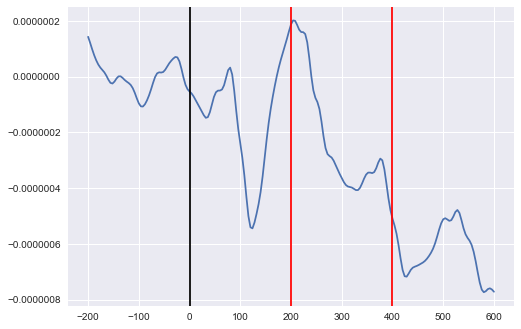

In [82]:
print(promedio_gral.shape)
plot(np.arange(201) * dur_sample * 1000 - 200, promedio_gral.mean(axis=0))
axvline(0, color='black')
axvline(200, color='red')
axvline(400, color='red')

In [83]:
f, Pxx = scs.welch(promedio_gral, fs=freq_sample)

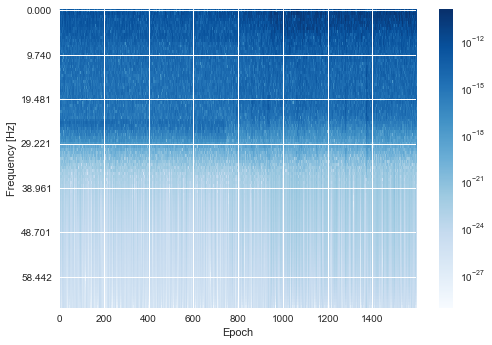

In [84]:
plt.figure()
imshow(Pxx.T, aspect='auto', norm=LogNorm(Pxx.min(), Pxx.max()), cmap=plt.cm.Blues)
tick_select = range(0, len(f), 15)
tick_labels = ['{:.3f}'.format(x) for x in f[tick_select]]
yticks(tick_select, tick_labels)
xlabel('Epoch')
ylabel('Frequency [Hz]')
colorbar()

### 1.a.2

#### Solo con P01

In [49]:
data = sio.loadmat('dataset/P01.mat')['data']
f, Pxx = scs.welch(data, fs=freq_sample, axis=2)
mean_epoch = np.mean(Pxx, axis=0)

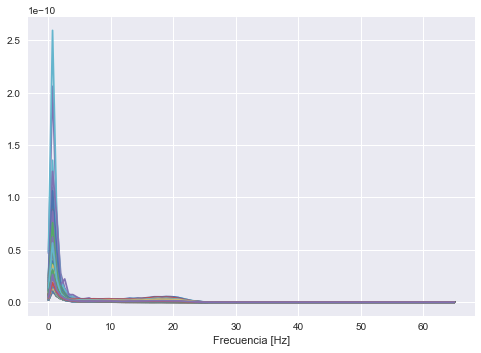

In [50]:
for i in range(N_ELECTRODOS):
    plot(f, mean_epoch[i, :])
xlabel('Frecuencia [Hz]')

#### Con todos los sujetos P

In [28]:
suma = np.zeros((N_ELECTRODOS, len(f)))

In [29]:
cant_p = 0
for nombre_matriz in todas_las_matrices:
    if os.path.basename(nombre_matriz).startswith('P'):
        data = sio.loadmat(nombre_matriz)['data']
        f, Pxx = scs.welch(data, fs=freq_sample, axis=2)
        mean_epoch = np.mean(Pxx, axis=0)
        suma += mean_epoch
        cant_p += 1

In [30]:
promedio = suma / cant_p

(0, 47)

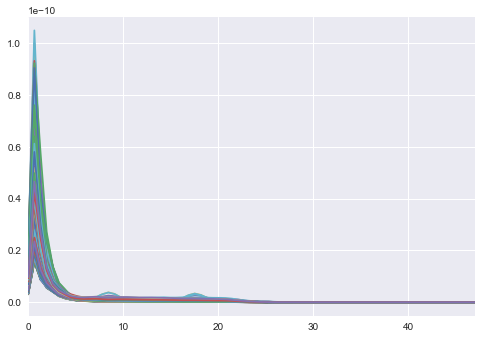

In [31]:
for i in range(N_ELECTRODOS):
    plot(f, promedio[i, :])
xlim(0, 47)

#### Con todos los sujetos S

In [32]:
suma = np.zeros((N_ELECTRODOS, len(f)))

In [33]:
cant_s = 0
for nombre_matriz in todas_las_matrices:
    if os.path.basename(nombre_matriz).startswith('S'):
        data = sio.loadmat(nombre_matriz)['data']
        f, Pxx = scs.welch(data, fs=freq_sample, axis=2)
        mean_epoch = np.mean(Pxx, axis=0)
        suma += mean_epoch
        cant_s += 1

[  0.           0.64935065   1.2987013    1.94805195   2.5974026
   3.24675325   3.8961039    4.54545455   5.19480519   5.84415584
   6.49350649   7.14285714   7.79220779   8.44155844   9.09090909
   9.74025974  10.38961039  11.03896104  11.68831169  12.33766234
  12.98701299  13.63636364  14.28571429  14.93506494  15.58441558
  16.23376623  16.88311688  17.53246753  18.18181818  18.83116883
  19.48051948  20.12987013  20.77922078  21.42857143  22.07792208
  22.72727273  23.37662338  24.02597403  24.67532468  25.32467532
  25.97402597  26.62337662  27.27272727  27.92207792  28.57142857
  29.22077922  29.87012987  30.51948052  31.16883117  31.81818182
  32.46753247  33.11688312  33.76623377  34.41558442  35.06493506
  35.71428571  36.36363636  37.01298701  37.66233766  38.31168831
  38.96103896  39.61038961  40.25974026  40.90909091  41.55844156
  42.20779221  42.85714286  43.50649351  44.15584416  44.80519481
  45.45454545  46.1038961   46.75324675  47.4025974   48.05194805
  48.701298

[  0.           0.64935065   1.2987013    1.94805195   2.5974026
   3.24675325   3.8961039    4.54545455   5.19480519   5.84415584
   6.49350649   7.14285714   7.79220779   8.44155844   9.09090909
   9.74025974  10.38961039  11.03896104  11.68831169  12.33766234
  12.98701299  13.63636364  14.28571429  14.93506494  15.58441558
  16.23376623  16.88311688  17.53246753  18.18181818  18.83116883
  19.48051948  20.12987013  20.77922078  21.42857143  22.07792208
  22.72727273  23.37662338  24.02597403  24.67532468  25.32467532
  25.97402597  26.62337662  27.27272727  27.92207792  28.57142857
  29.22077922  29.87012987  30.51948052  31.16883117  31.81818182
  32.46753247  33.11688312  33.76623377  34.41558442  35.06493506
  35.71428571  36.36363636  37.01298701  37.66233766  38.31168831
  38.96103896  39.61038961  40.25974026  40.90909091  41.55844156
  42.20779221  42.85714286  43.50649351  44.15584416  44.80519481
  45.45454545  46.1038961   46.75324675  47.4025974   48.05194805
  48.701298

In [34]:
promedio = suma / cant_s

(0, 47)

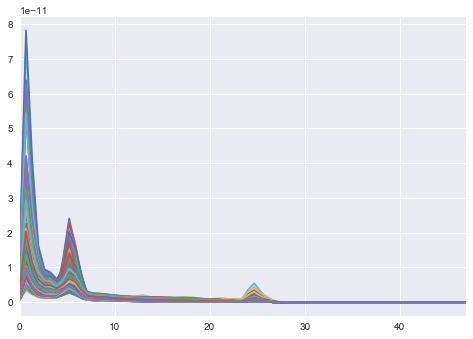

In [35]:
for i in range(N_ELECTRODOS):
    plot(f, promedio[i, :])
xlim(0, 47)